In [103]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import lightning as L
from torchvision.models import vit_b_16 # pretrained model
from torchsummary import summary
import torchmetrics

import brain_tumor_dataset as btd

# Pre trained model

In [104]:
# Define the transformation for the images
transform = transforms.Compose([
	transforms.Grayscale(num_output_channels=3),   # convert to 3 channels
	transforms.Resize((224, 224)),                 # resize to 224x224
	transforms.ToTensor(),
])

# Load your datasets with the defined transformations
train_dataset = btd.BrainTumorDataset(btd.TRAIN_DATA_PATH, transform=transform)
test_dataset = btd.BrainTumorDataset(btd.TEST_DATA_PATH, transform=transform)

val_size = len(test_dataset) // 2
test_size = len(test_dataset) - val_size
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset), len(test_dataset), len(val_dataset)

(5712, 656, 655)

In [105]:
import numpy as np

# Define the PyTorch Lightning Module
class BrainTumorClassifier(L.LightningModule):
	def __init__(self, 
			  learning_rate=1e-4, 
			  pretrained_weights = "IMAGENET1K_V1",
			  weights_path=None):
		super().__init__()
		# Initialize the model with the pre-trained ViT
		self.model = vit_b_16(weights=pretrained_weights)
		self.model.heads = torch.nn.Linear(self.model.hidden_dim, 4)  # Modify for 4 classes

		# Load the weights if provided
		if weights_path:
			self.load_from_checkpoint(weights_path, map_location=self.device)

		# Define loss function and learning rate
		self.criterion = torch.nn.CrossEntropyLoss()
		self.learning_rate = learning_rate

		# Initialize accuracy metric for logging
		self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)
		self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)

		self.attention_maps = {}  # To store attention maps

	def forward(self, x):
		return self.model(x)

	def training_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
		self.train_accuracy(outputs, labels)
		self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True)

		return loss
	
	def validation_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('val_loss', loss, on_epoch=True, prog_bar=True)
		self.val_accuracy(outputs, labels)
		self.log('val_acc', self.val_accuracy, on_epoch=True, prog_bar=True)

		return loss

	def test_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('test_loss', loss, on_epoch=True, prog_bar=True)
		self.val_accuracy(outputs, labels)
		self.log('test_acc', self.val_accuracy, on_epoch=True, prog_bar=True)

		self.log_attention_maps(inputs, batch_idx)  # Save attention maps

		return loss
	
	def configure_optimizers(self):
		return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
	
	def register_attention_hooks(self):
		"""Register hooks to capture attention maps."""
		self.attention_maps.clear()  # Reset attention maps

		def hook_fn(module, input, output, module_name):
			module_name = module_name.split(".")[2]  # Get the layer name

			q, k, _ = input
			self.attention_maps[module_name] = torch.nn.functional.softmax(q @ k.transpose(-2, -1))  # Save attention map

		# Register hooks on all MultiheadAttention layers
		for i, module in self.model.named_modules():
			if isinstance(module, torch.nn.MultiheadAttention):
				module.register_forward_hook(lambda module, input, output, module_name=i: hook_fn(module, input, output, module_name))
	
	def on_test_start(self):
		# Register the hook to each multi-head attention layer before testing
		self.register_attention_hooks()

	def log_attention_maps(self, inputs, batch_idx):
			"""Log attention maps overlaid on the original image using Lightning's logger."""
			batch_size = inputs.size(0)
			for i in range(batch_size):
				average_attention_map = None
				num_layers = len(self.attention_maps)
				for layer, attention in self.attention_maps.items():
					# Get the attention map for the first image in the batch
					attention_map = attention[i]  # Shape: [num_tokens, embedding_size]
					
					# Compute cosine similarity between class token and patches
					class_token_embedding = attention_map[0, :]  # Shape: (embedding_size)
					num_patches_side = int((attention_map.size(0) - 1) ** 0.5)
					attention_map = class_token_embedding[1:].view(num_patches_side, num_patches_side, -1).clone()
					
					# Accumulate attention maps
					if average_attention_map is None:
						average_attention_map = attention_map
					else:
						average_attention_map += attention_map
					# TODO: Compute similarity between class token and patches

					# TODO: Create overlay image using attention map and original image

					# Log the overlay image
					# self.logger.experiment.add_image(
					# 	f"AttentionMap/{layer}_{batch_idx}_{i}", 
					# 	np.transpose(overlay_image, (2, 0, 1)),  # Change shape to [C, H, W]
					# 	global_step=self.global_step
					# )
					# Plot the attention map
				average_attention_map /= num_layers
				plt.figure(figsize=(8, 8))
				plt.imshow(average_attention_map.cpu().detach().numpy(), cmap='coolwarm', interpolation='nearest')
				plt.colorbar()
				plt.title(f'Average Attention Map - Image {i}')
				plt.show()

# Create the model instance
# weights_path = "./model_pretrained.pth"
model = BrainTumorClassifier()

# Define callbacks
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
	dirpath="checkpoints",                   # Directory to save checkpoints
	filename="epoch-{epoch:02d}-val_loss-{val_loss:.2f}",  # Naming pattern
	save_top_k=-1,                          # Save all checkpoints
	save_weights_only=True,                 # Save only weights, not optimizer state
	every_n_epochs=1,                       # Save at every epoch
)

early_stopping_callback = L.pytorch.callbacks.EarlyStopping(
	monitor="val_loss",                     # Metric to monitor
	patience=5,                             # Stop training if no improvement for 5 epochs
	mode="min",                             # Stop when `val_loss` stops decreasing
	verbose=True,
)

logger = L.pytorch.loggers.TensorBoardLogger("logs", name="vit_b_16")


# Define the PyTorch Lightning Trainer
trainer = L.Trainer(max_epochs=10, 
					accelerator="auto", 
					logger=logger,
					callbacks=[checkpoint_callback, early_stopping_callback])


MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
)
MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
)
MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
)
MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
)
MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
)
MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
)
MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
)
MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
)
MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_f

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
# Train the model
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Testing DataLoader 0:   0%|          | 0/21 [00:00<?, ?it/s]

C:\Users\NIels\AppData\Local\Temp\ipykernel_22820\51673527.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.attention_maps[module_name] = torch.nn.functional.softmax(q @ k.transpose(-2, -1))  # Save attention map


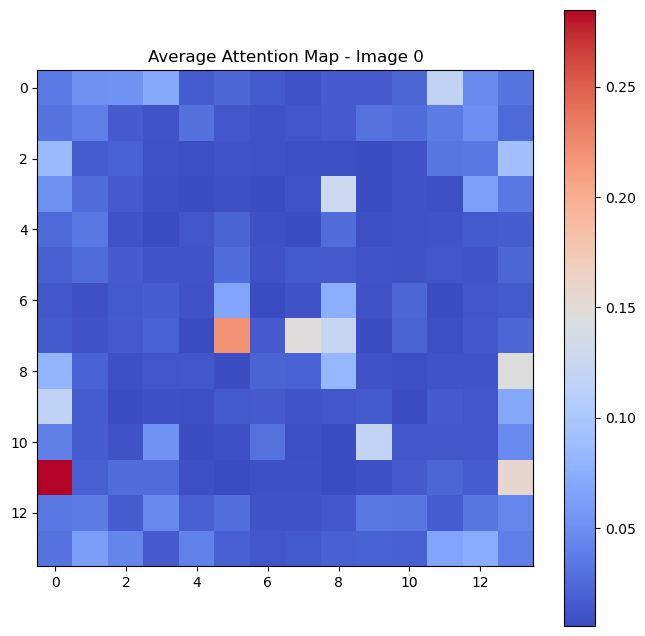

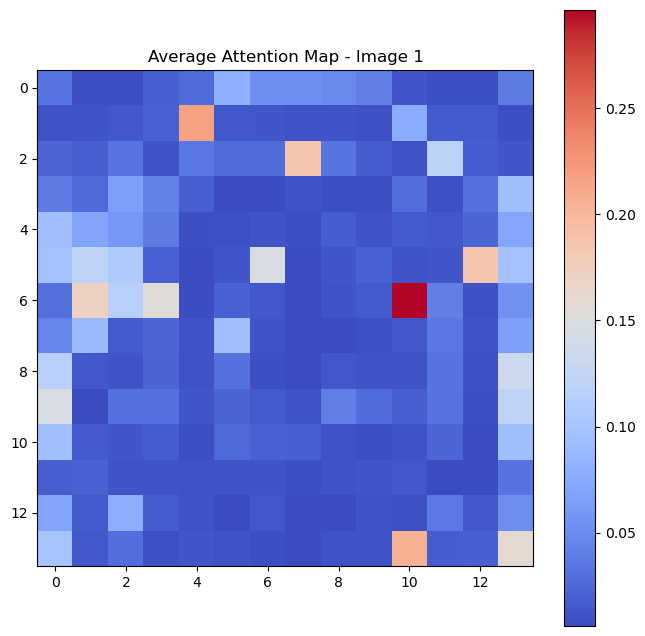

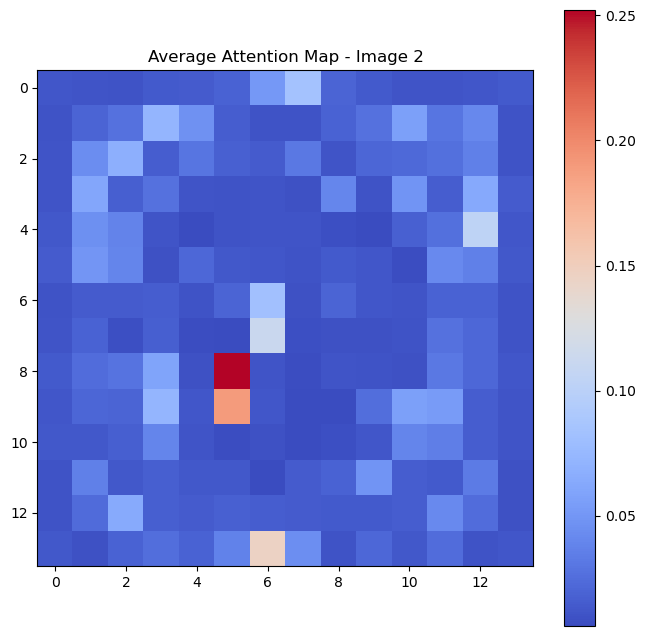

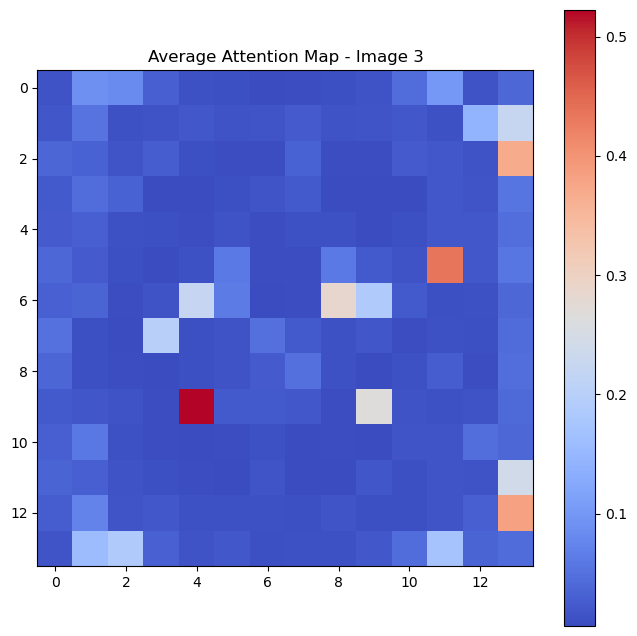

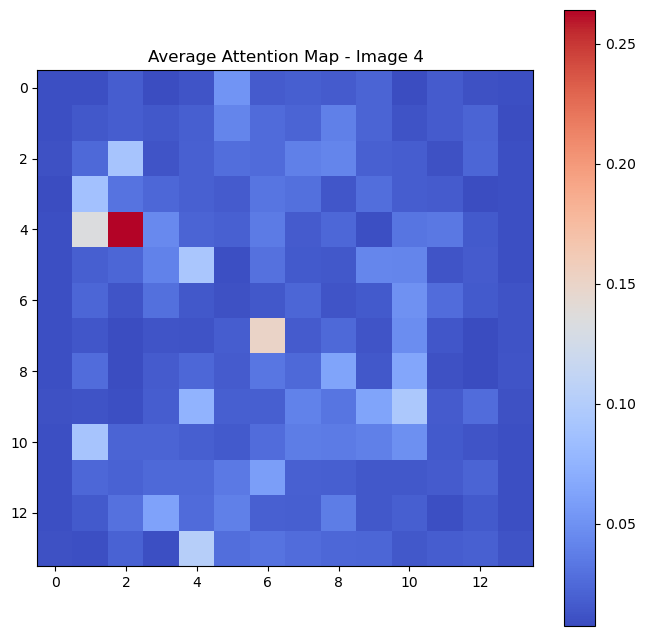

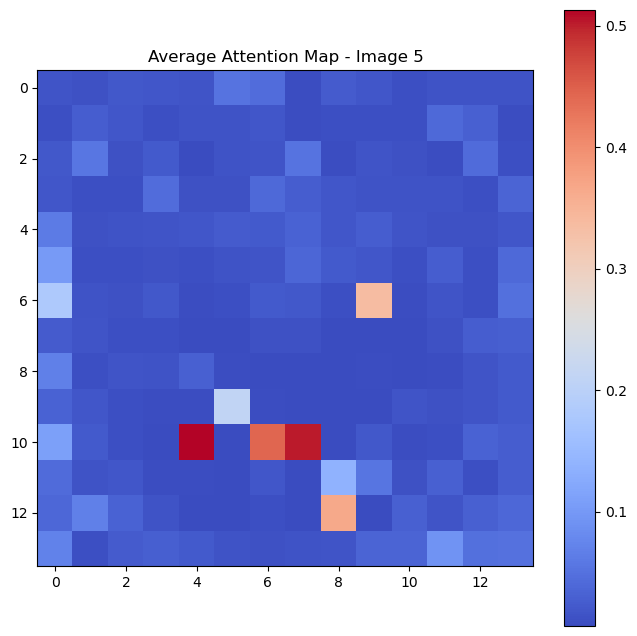

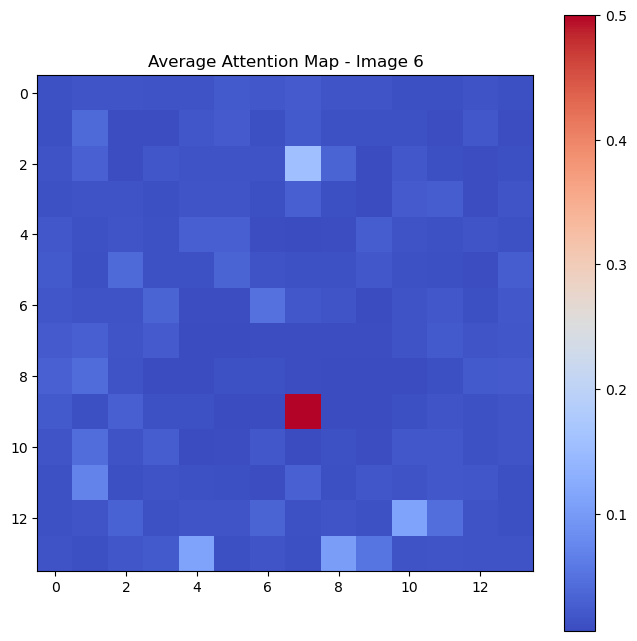

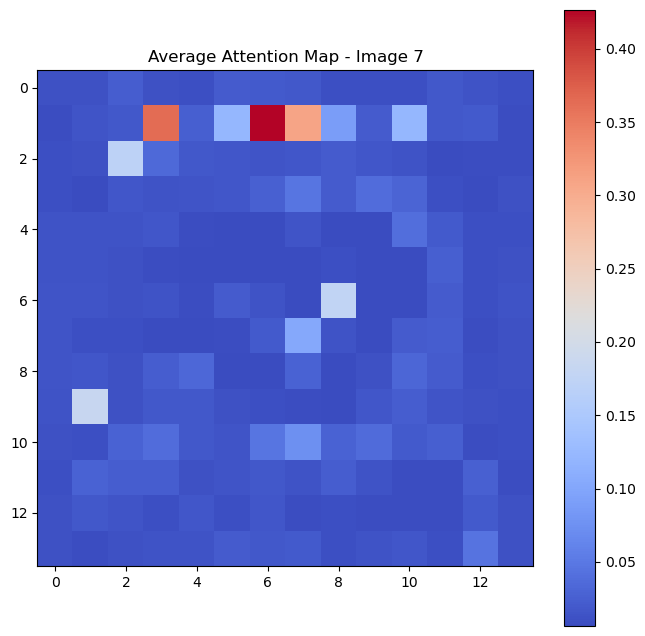

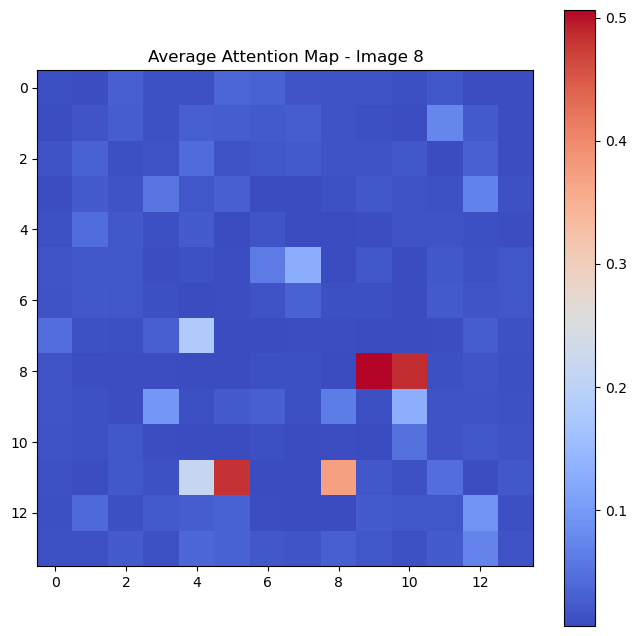

Testing DataLoader 0:   0%|          | 0/21 [03:38<?, ?it/s]


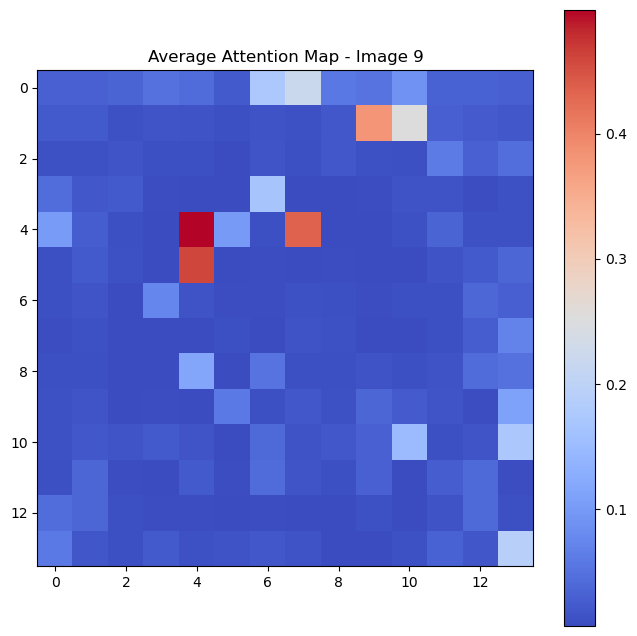

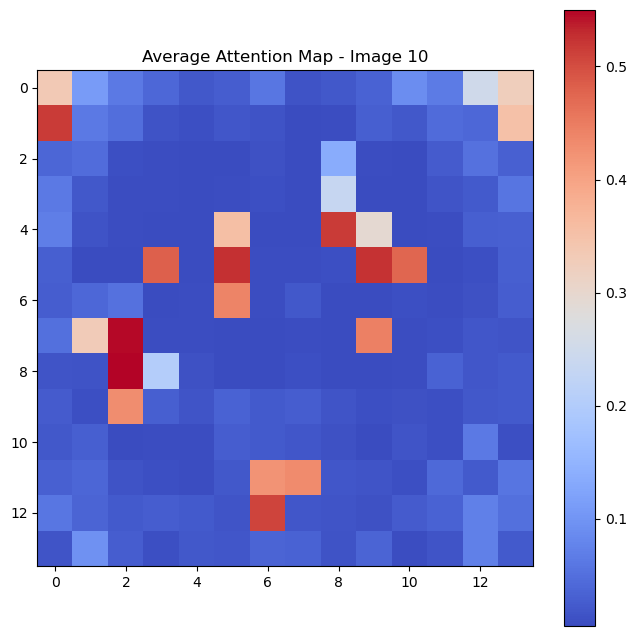

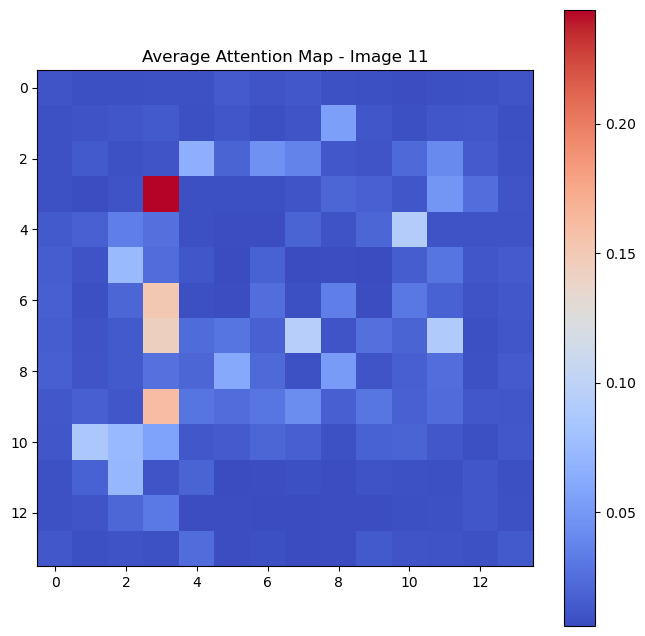

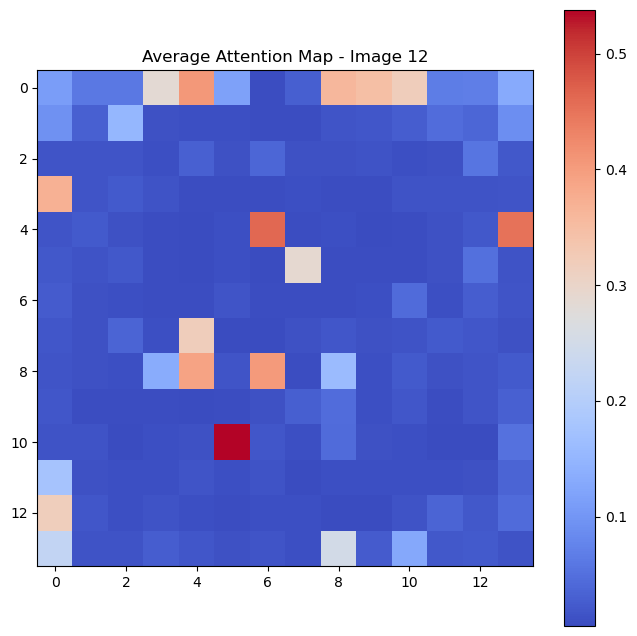

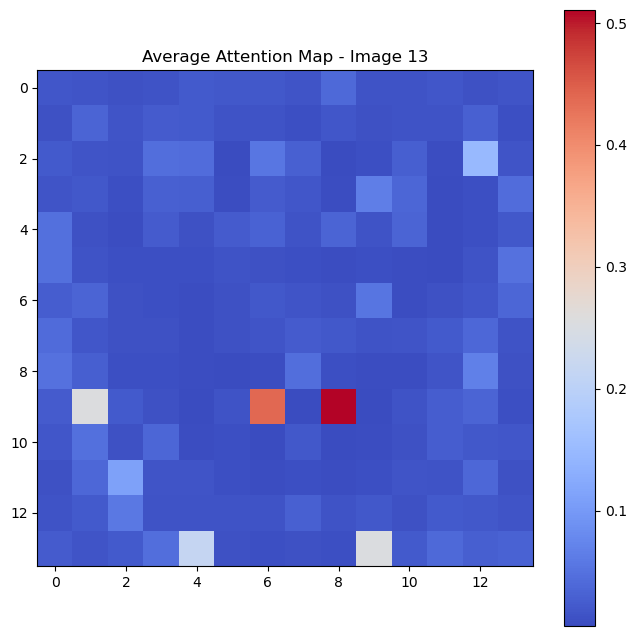

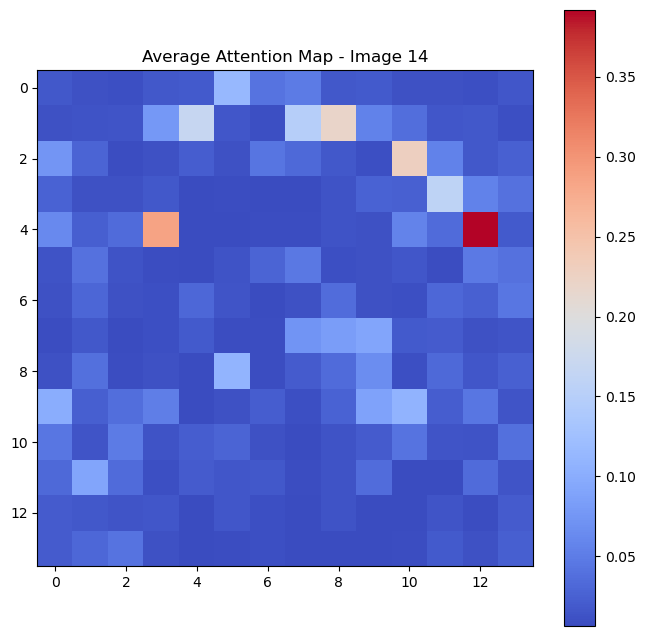

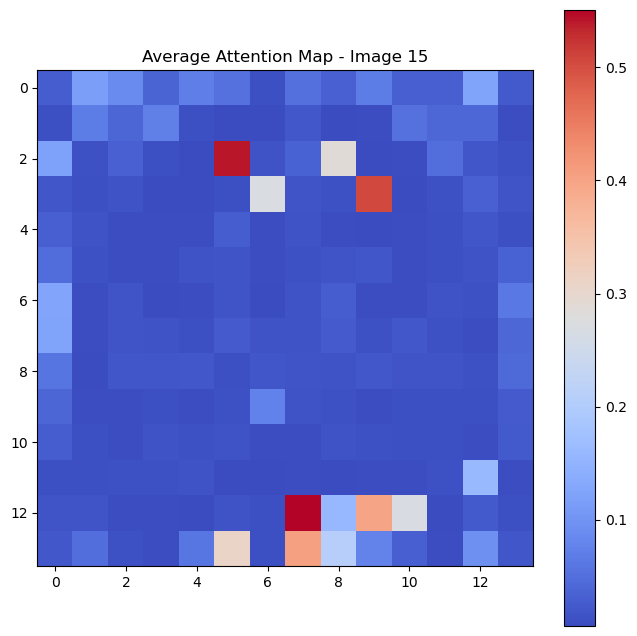

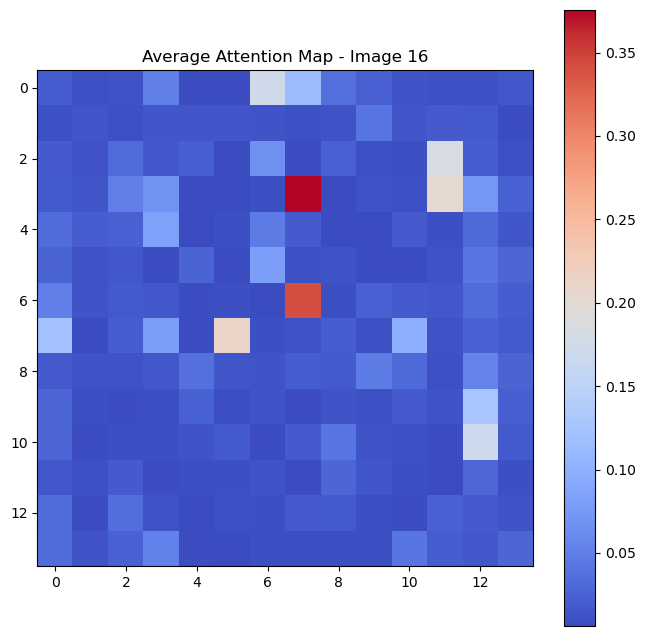

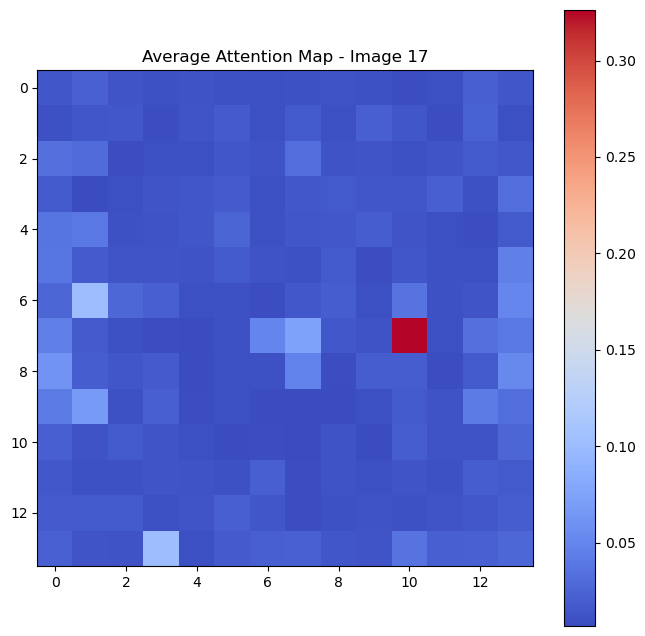

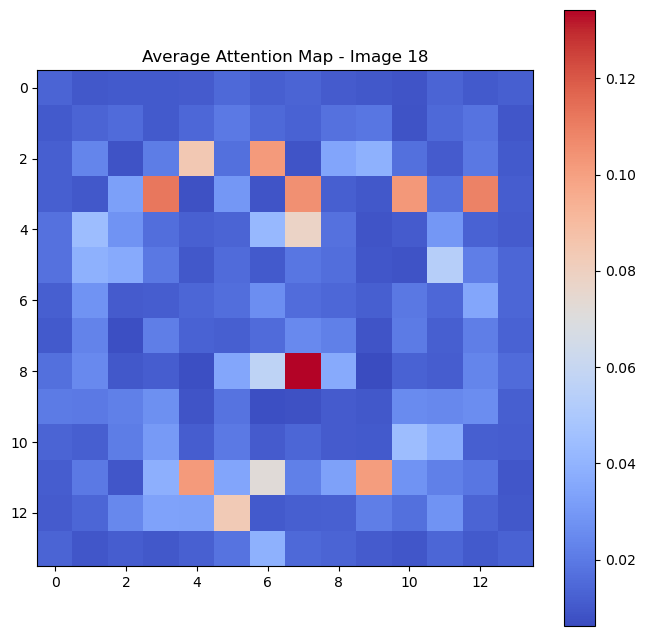

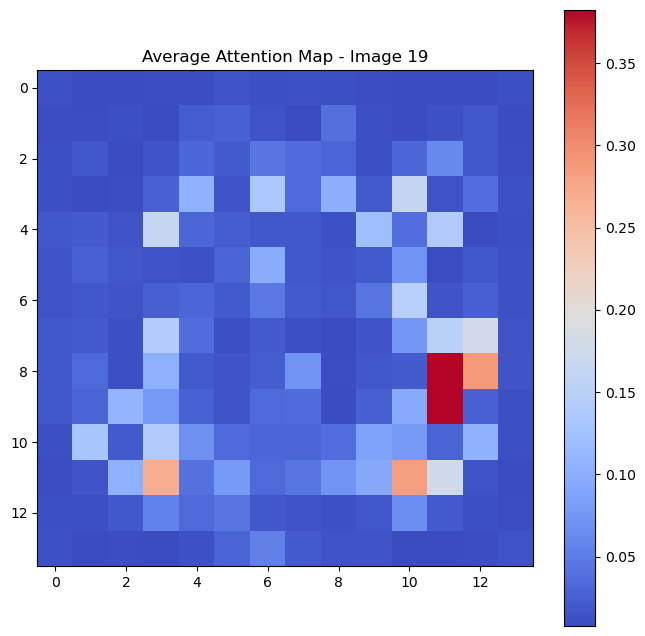

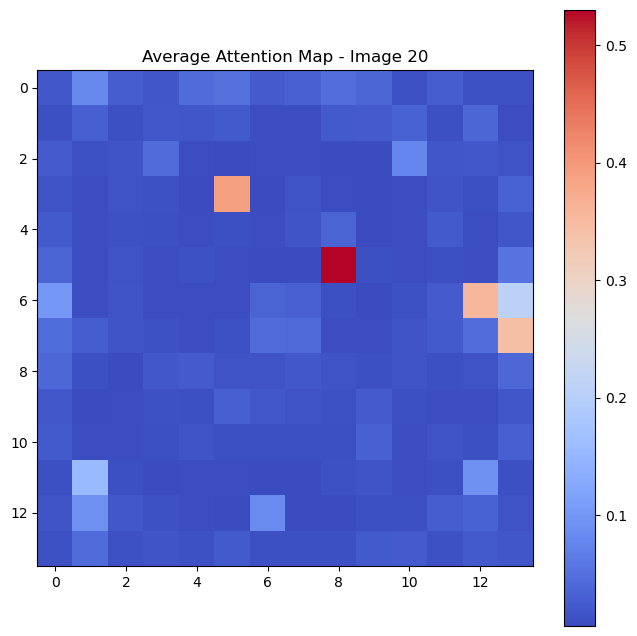

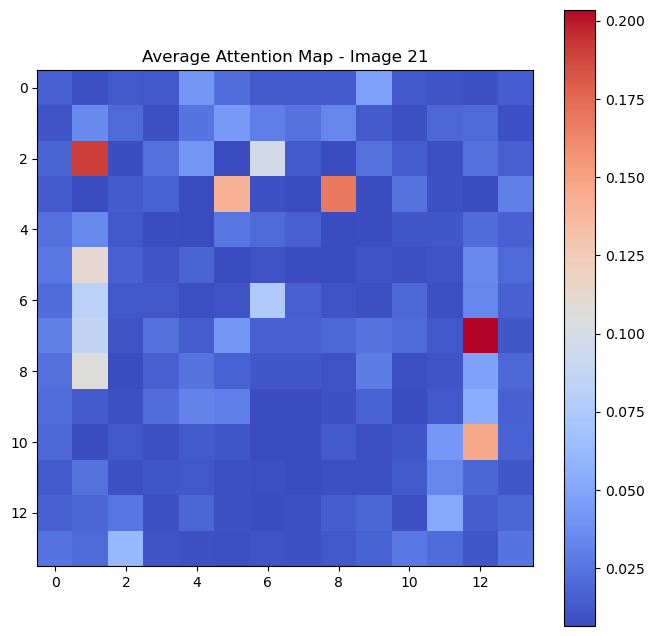

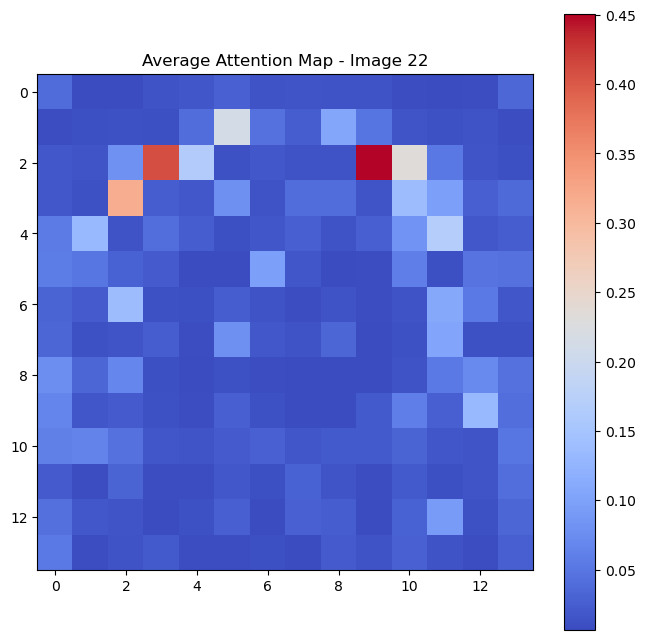

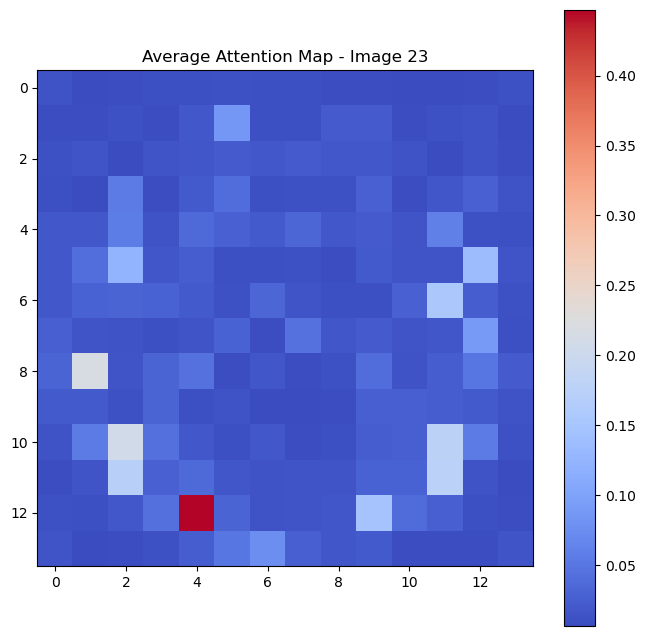

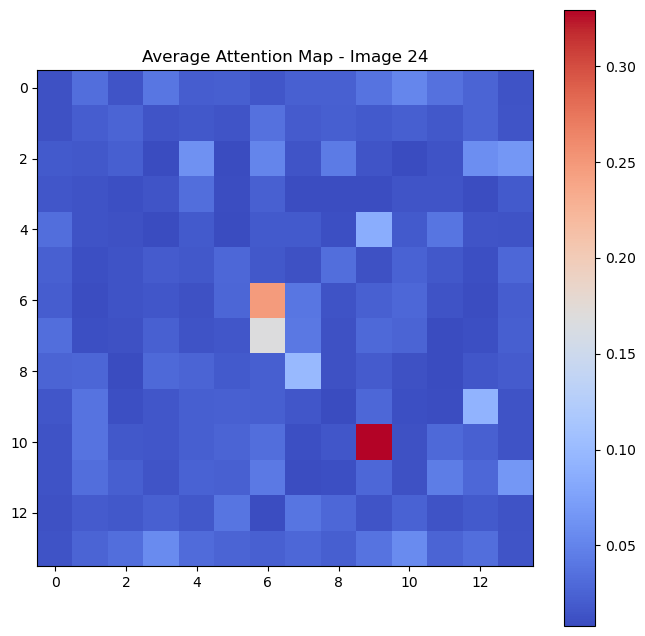

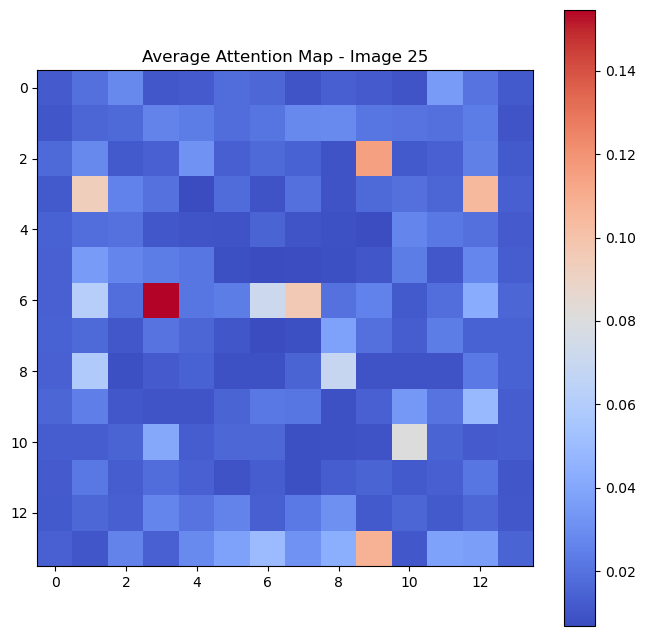

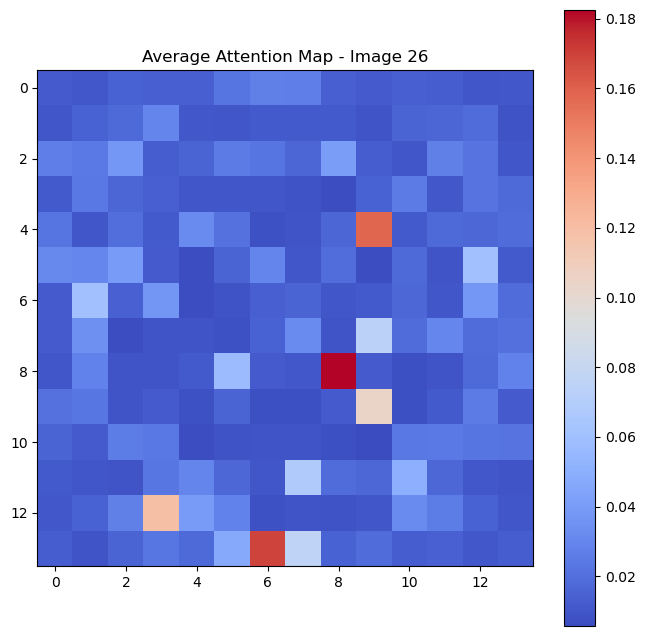

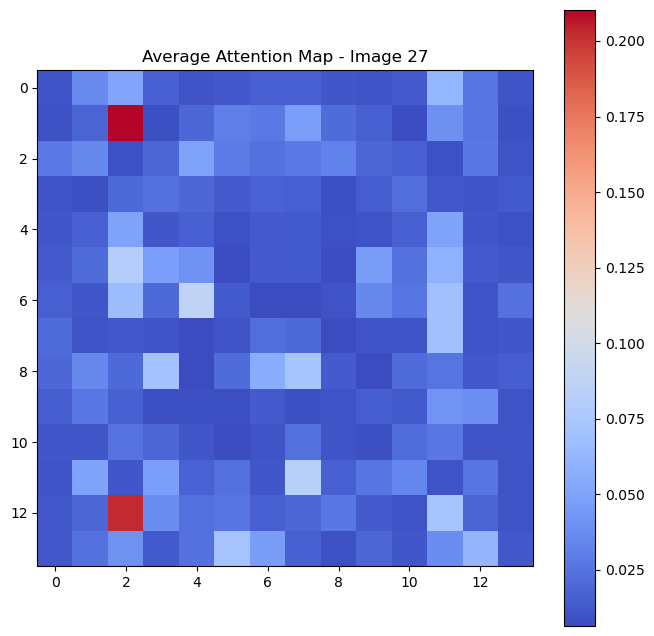

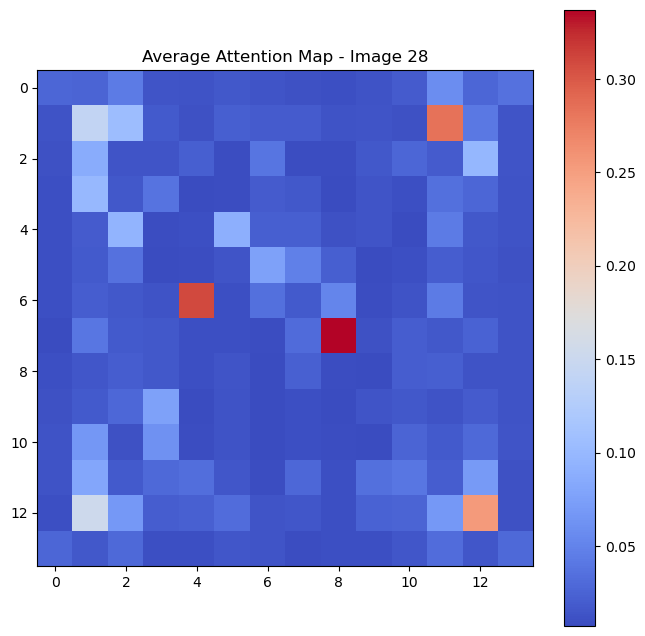

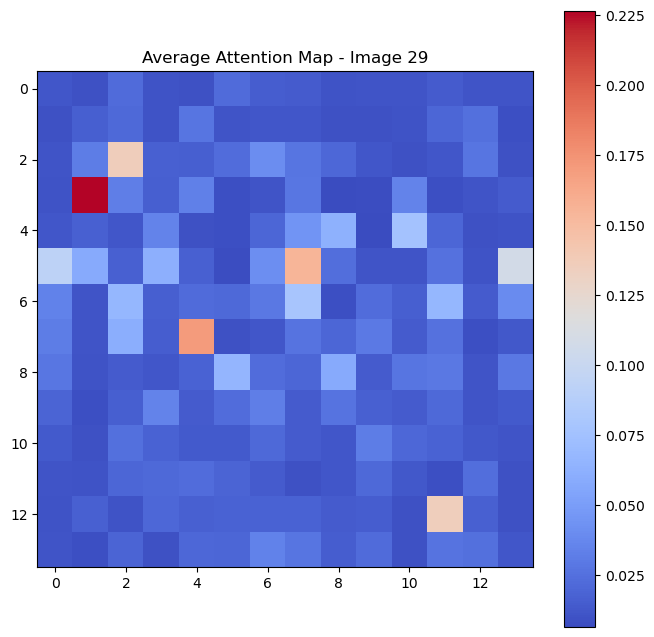

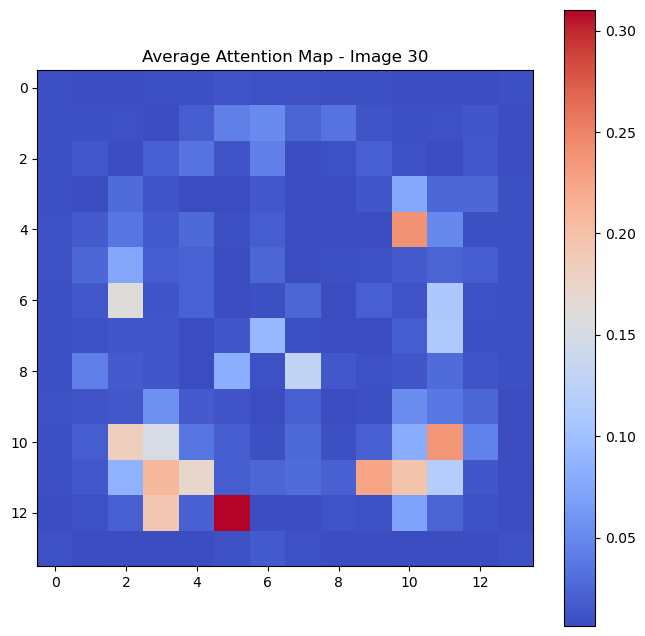

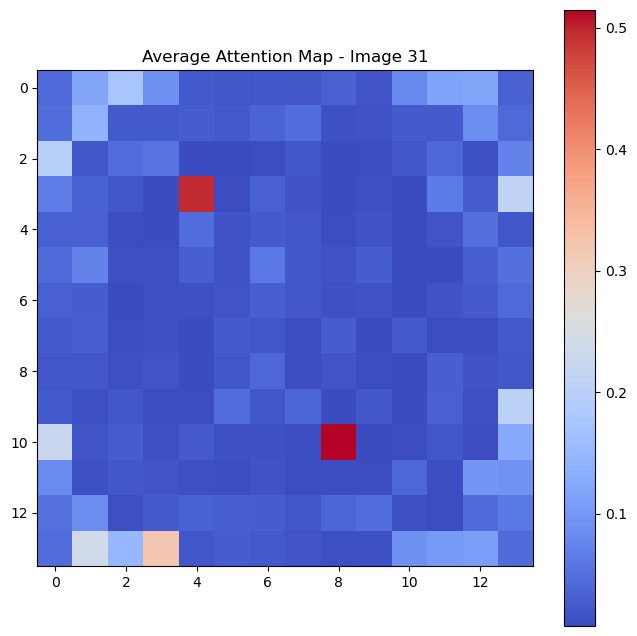

Testing DataLoader 0:   5%|▍         | 1/21 [00:08<02:54,  0.11it/s]

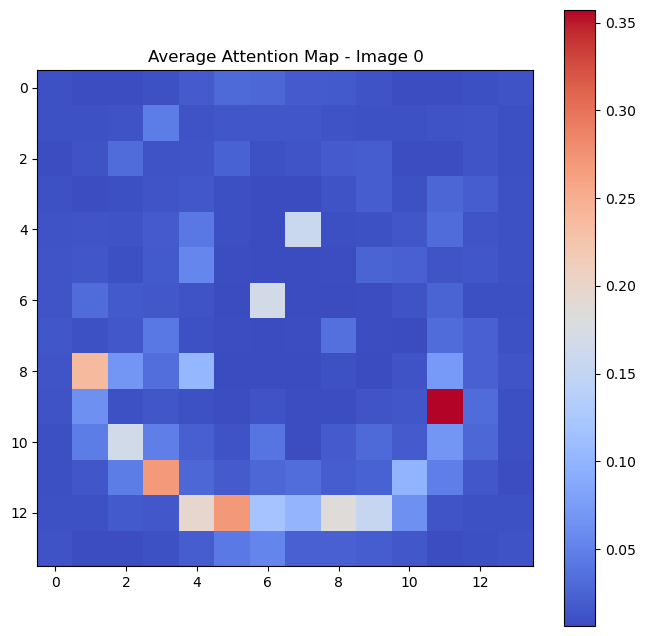

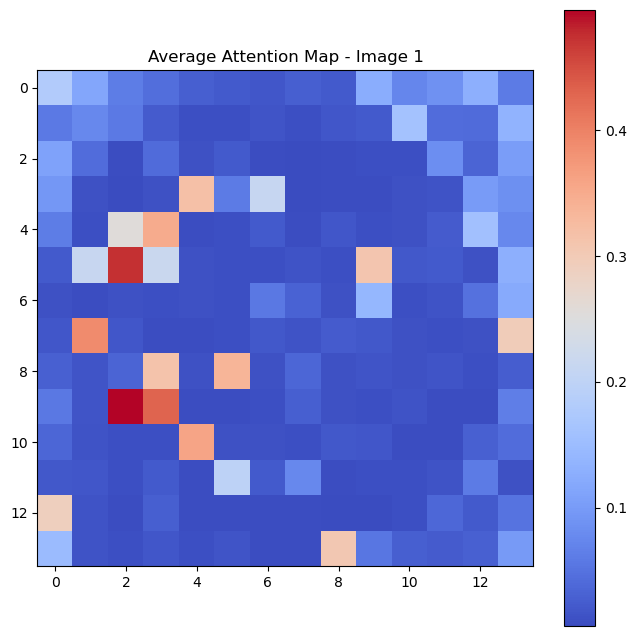

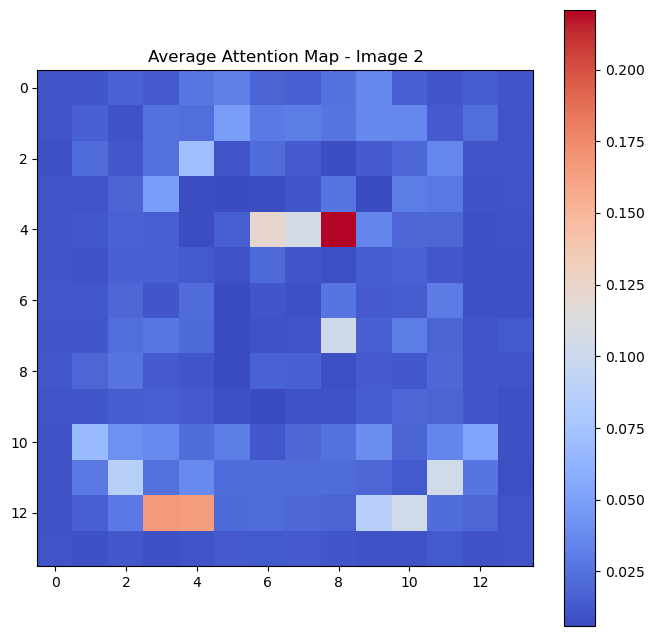

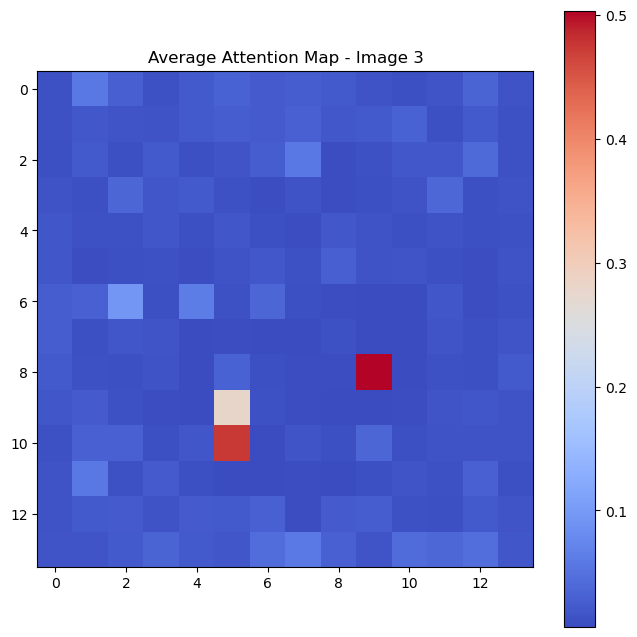

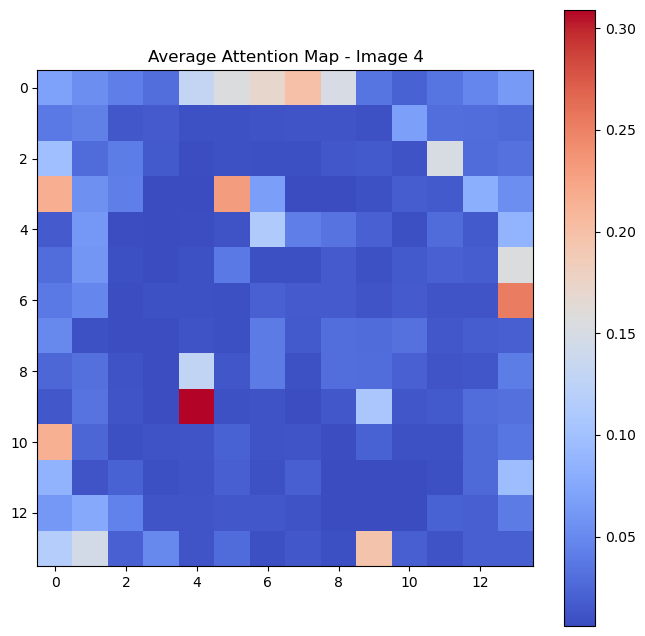

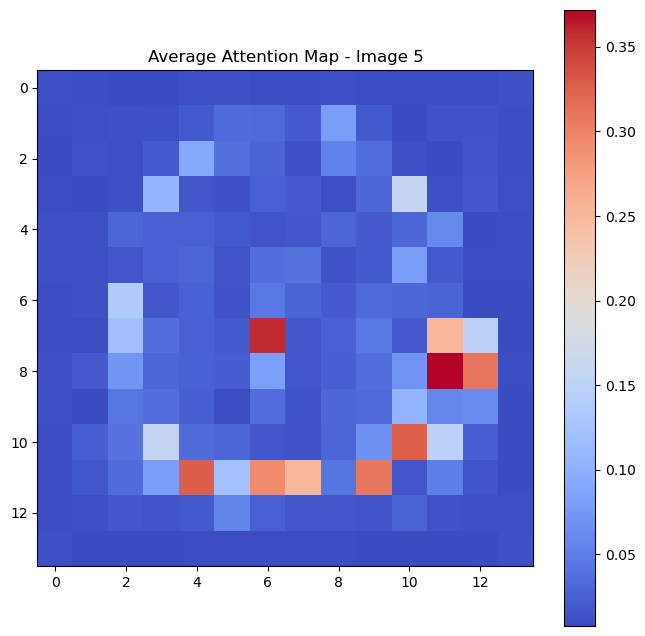

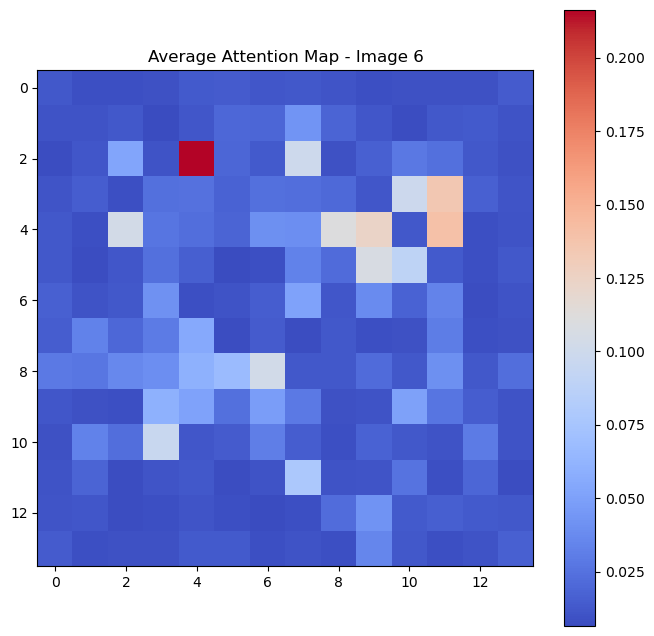

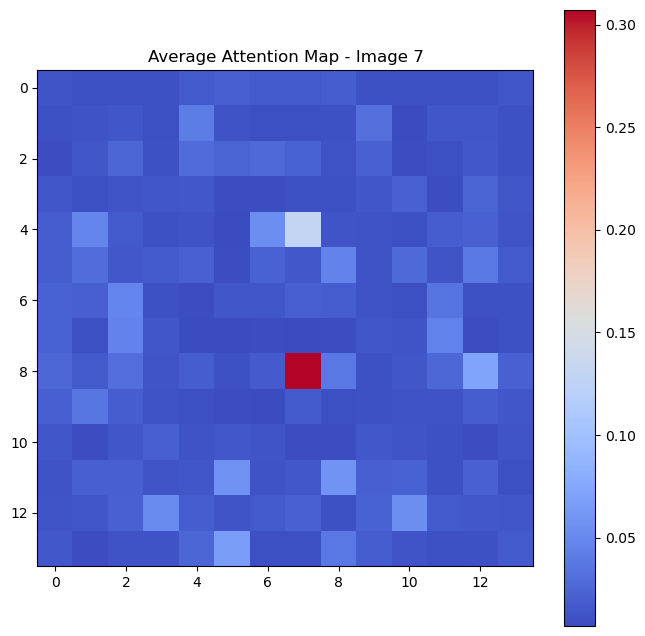

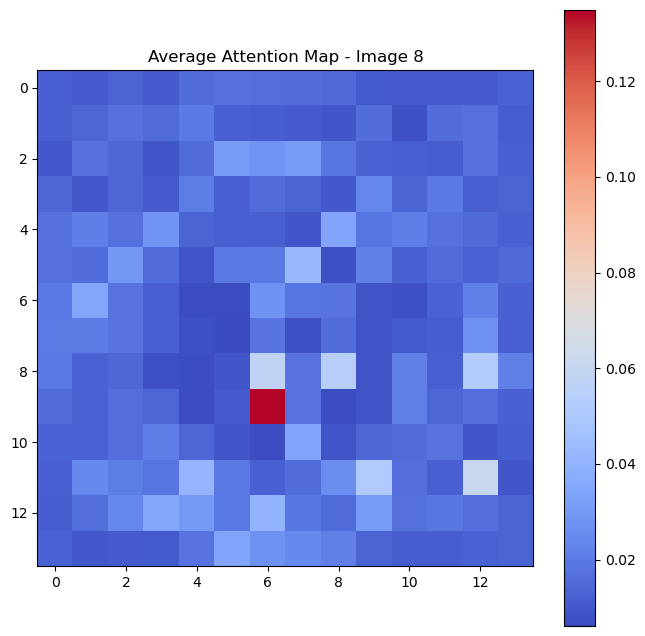

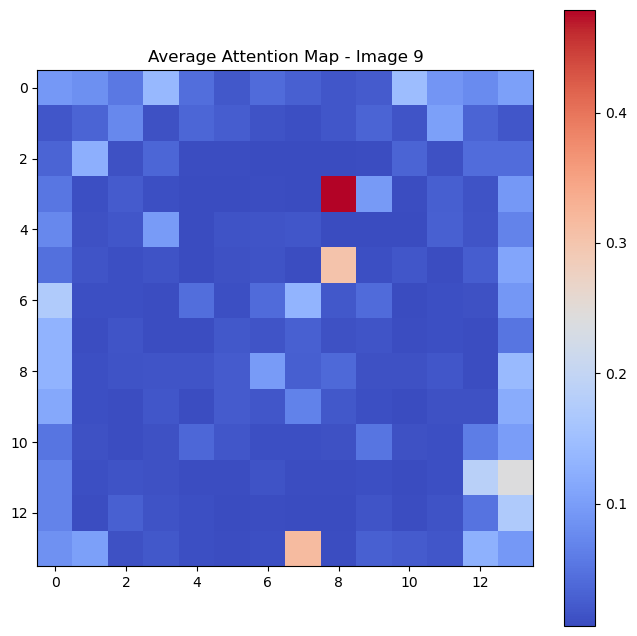

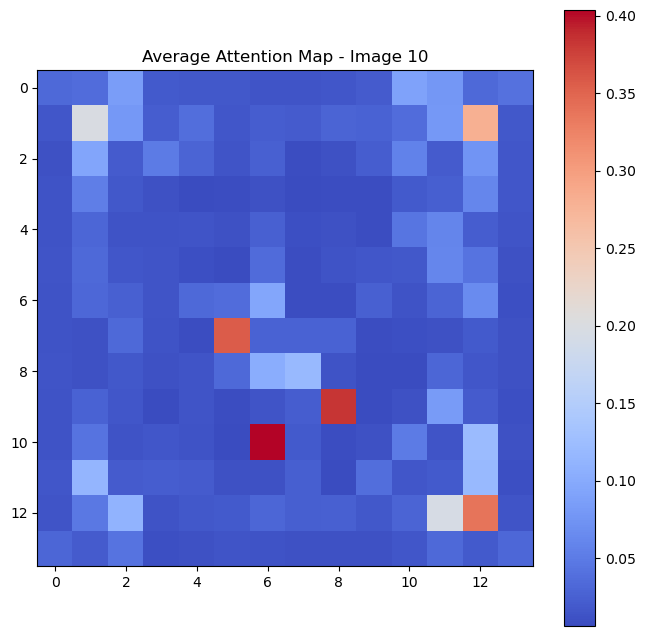

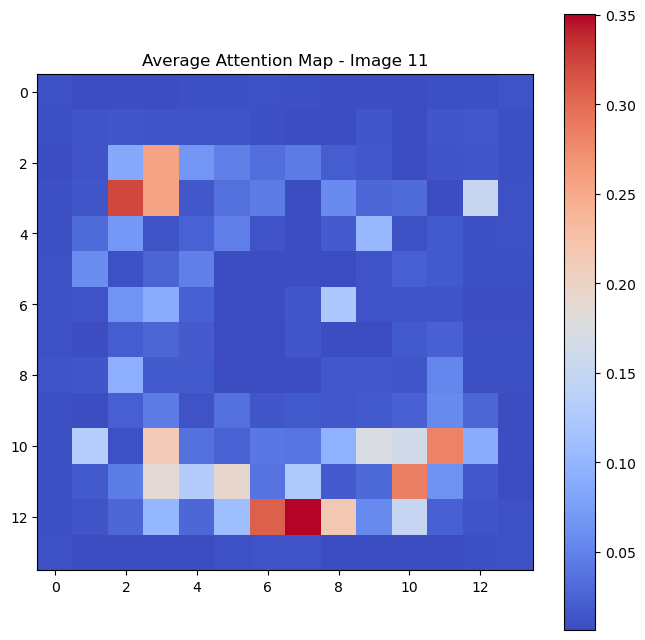

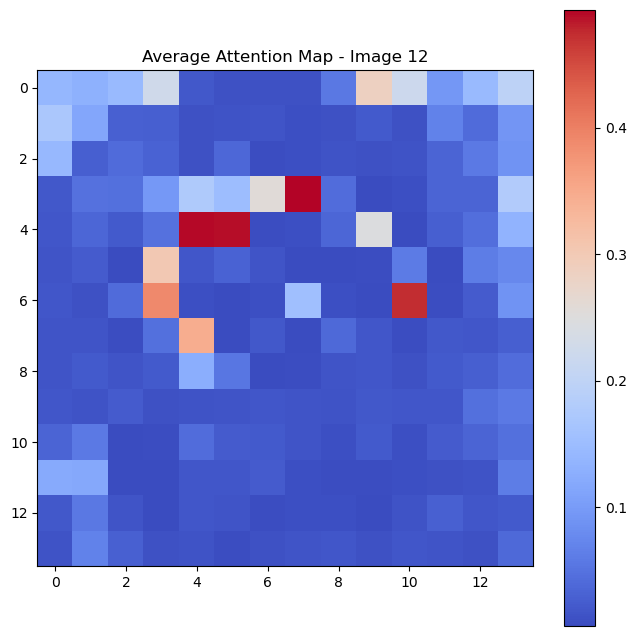

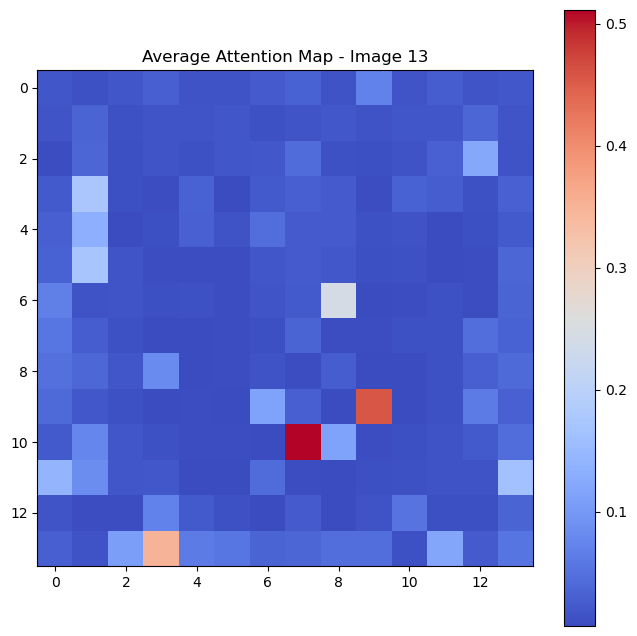

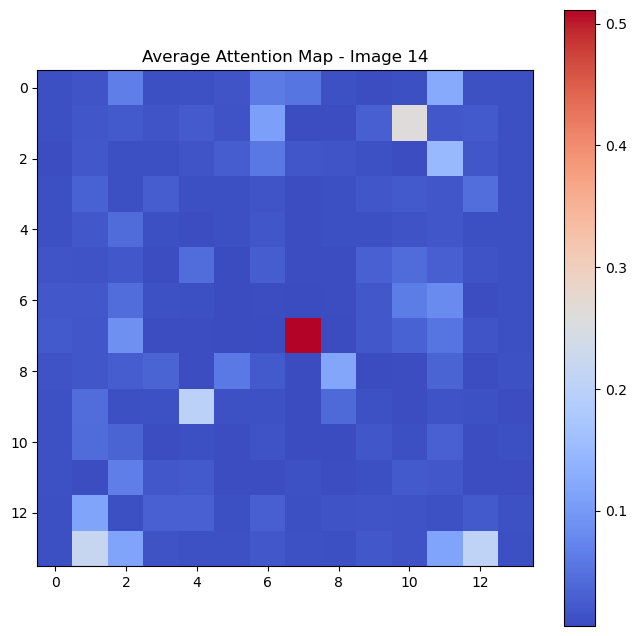

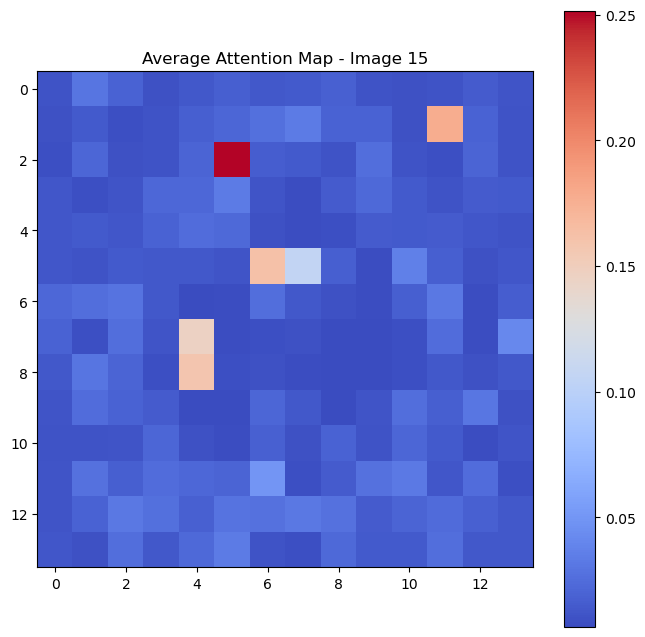

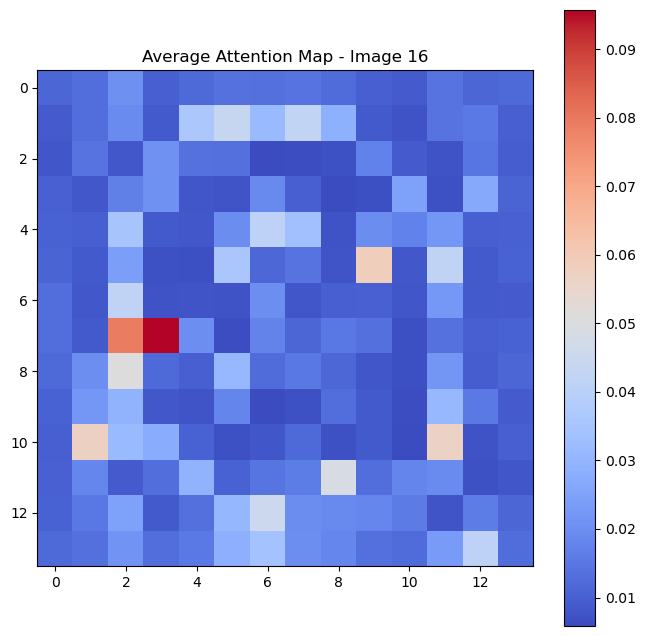

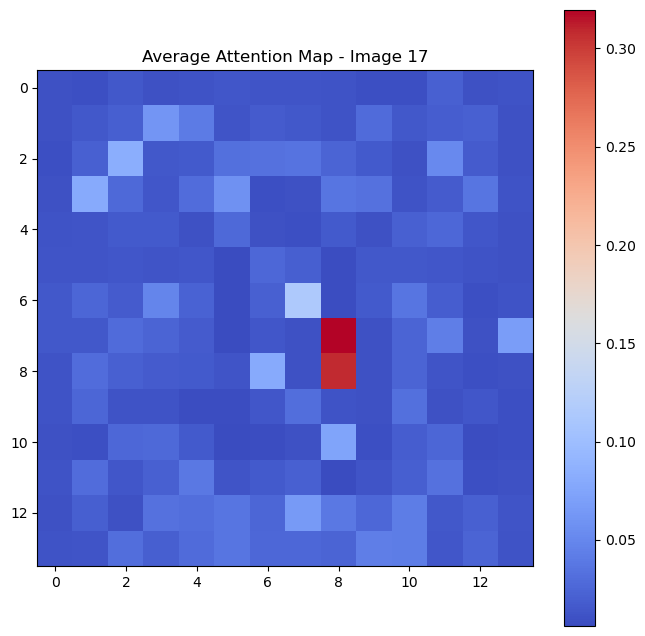

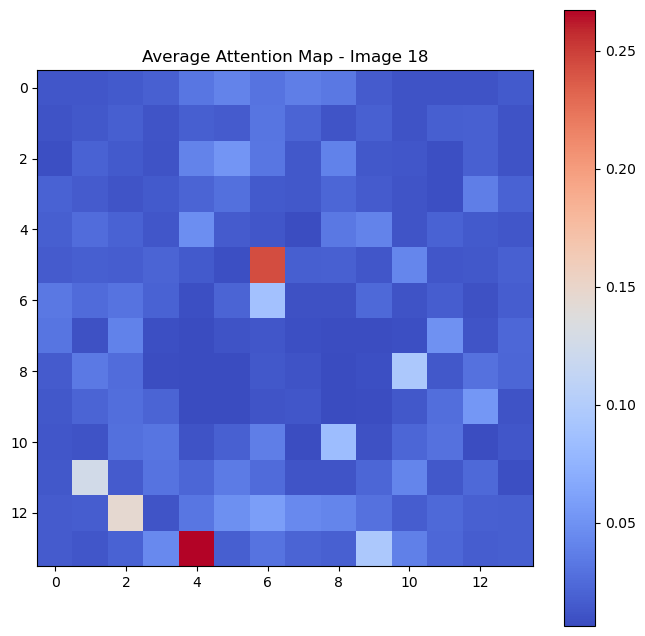

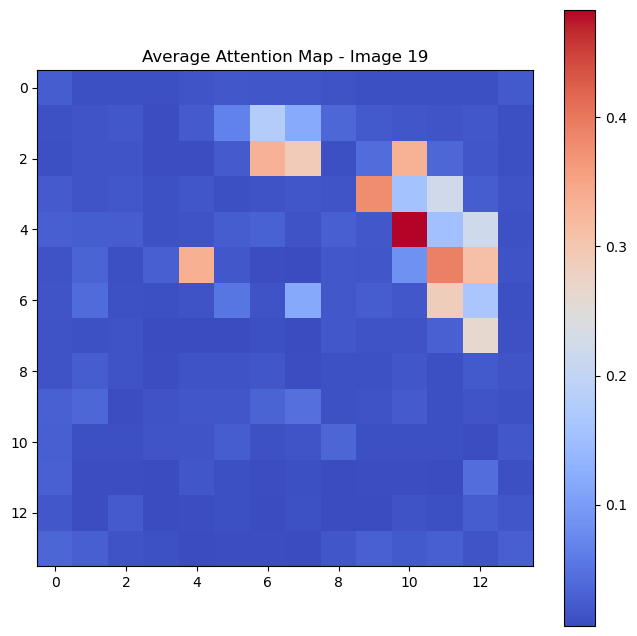

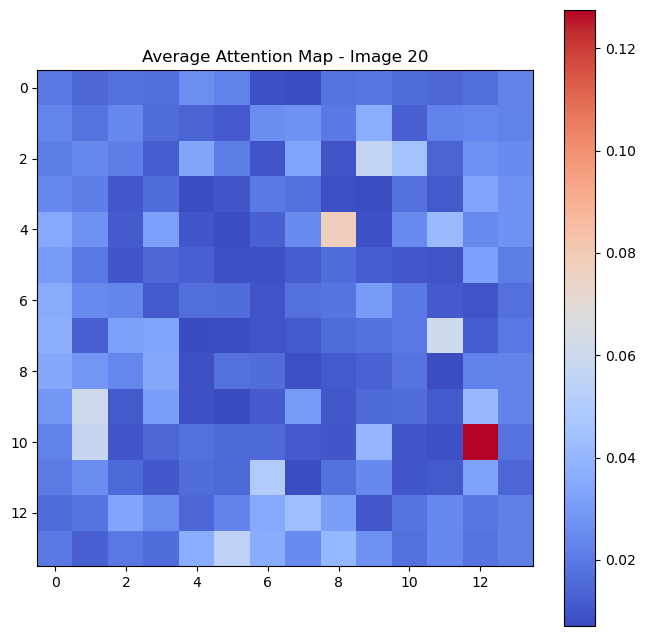

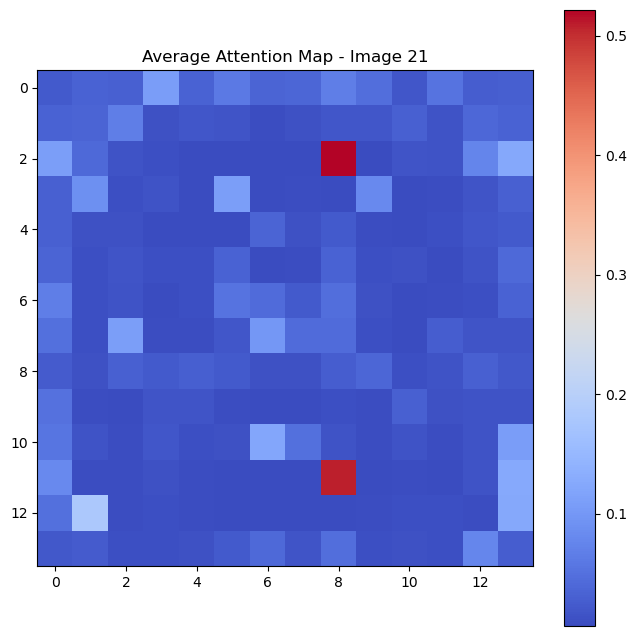

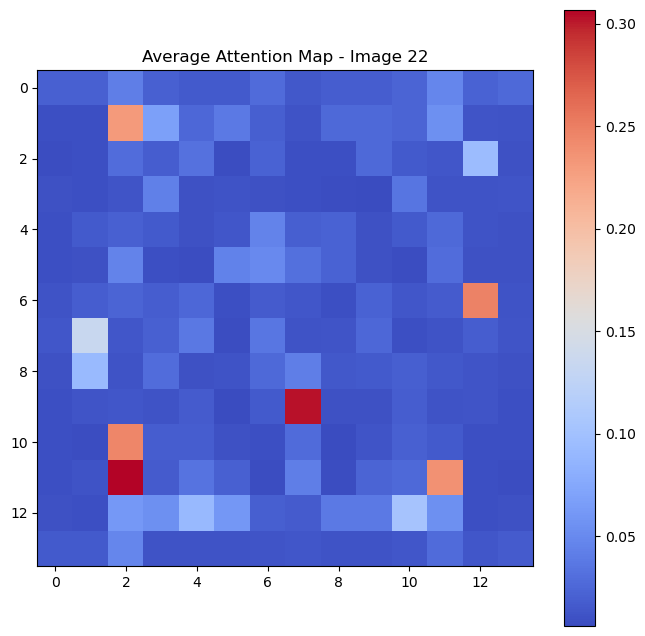

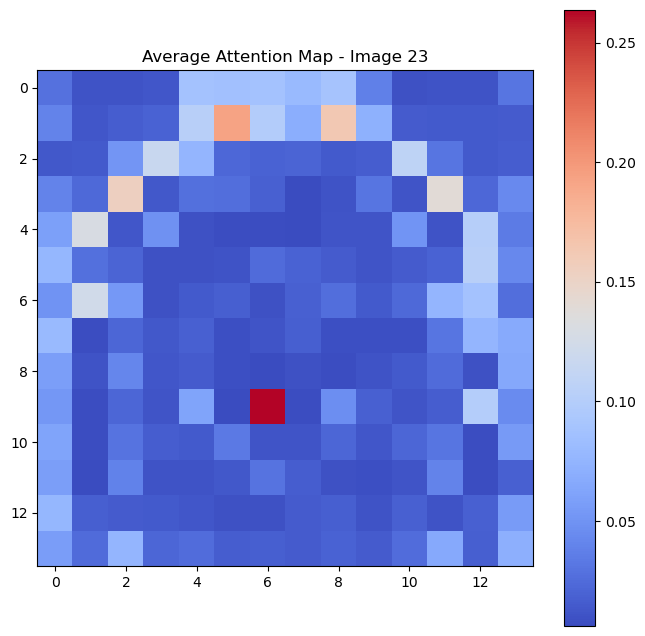

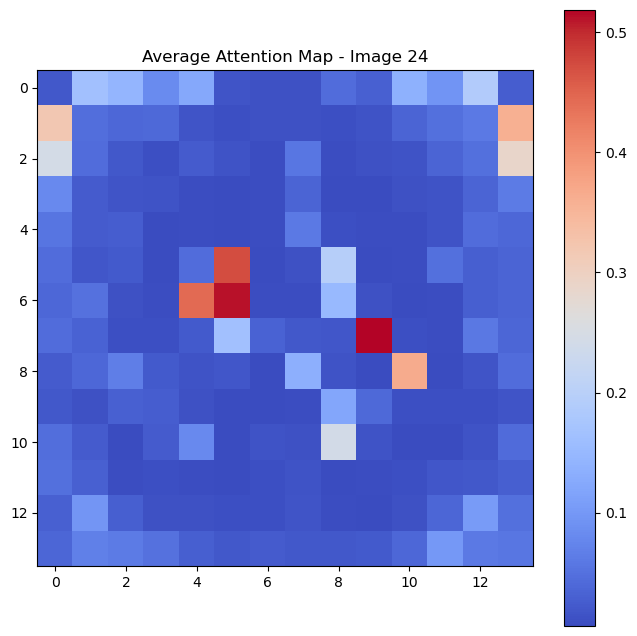

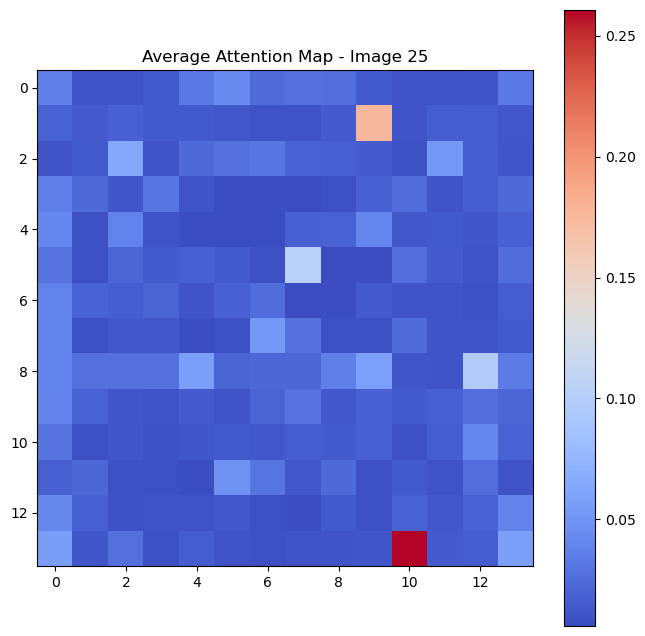

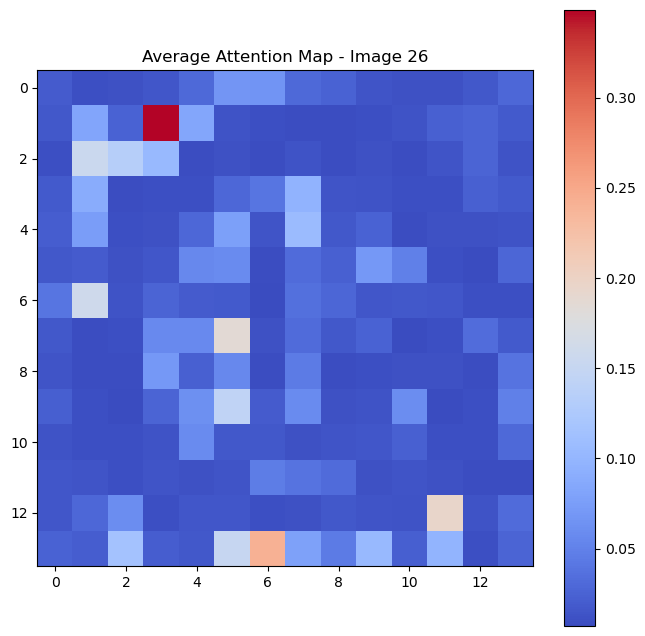

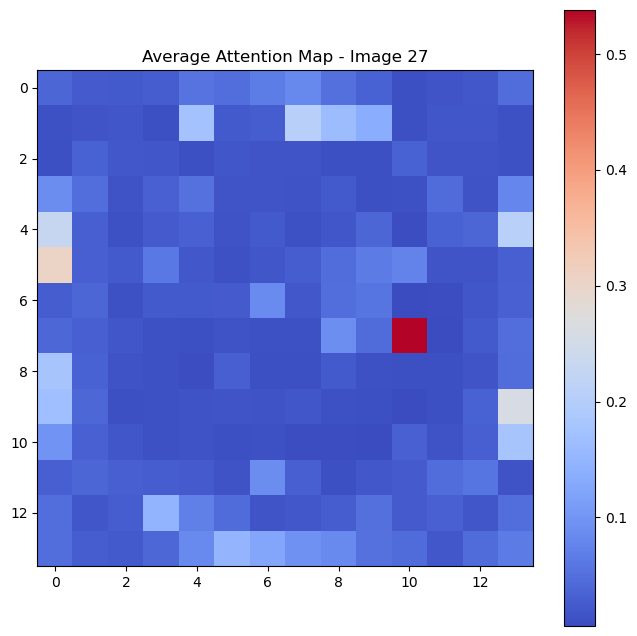

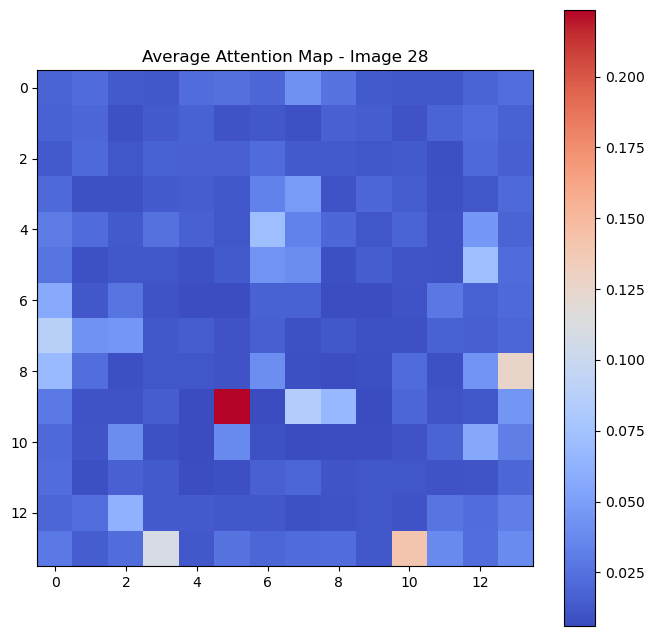

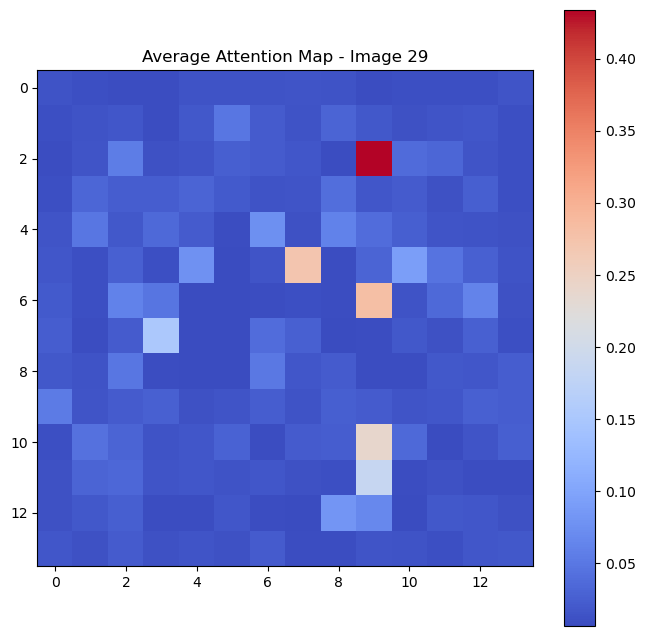

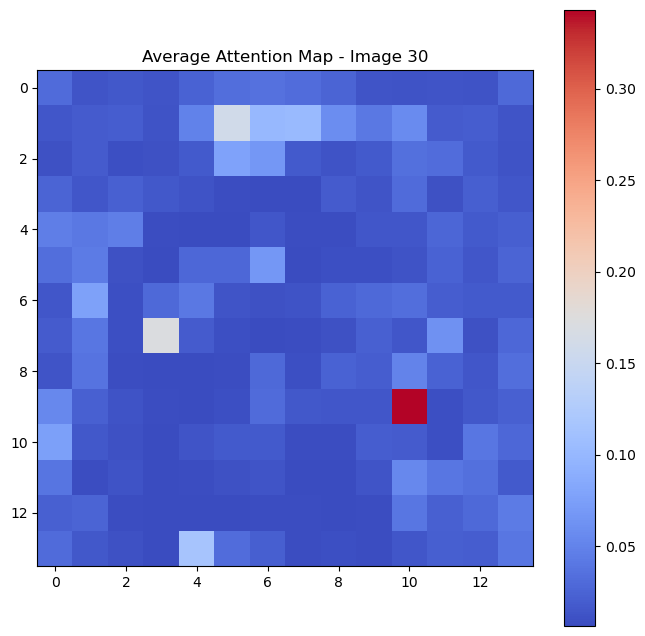

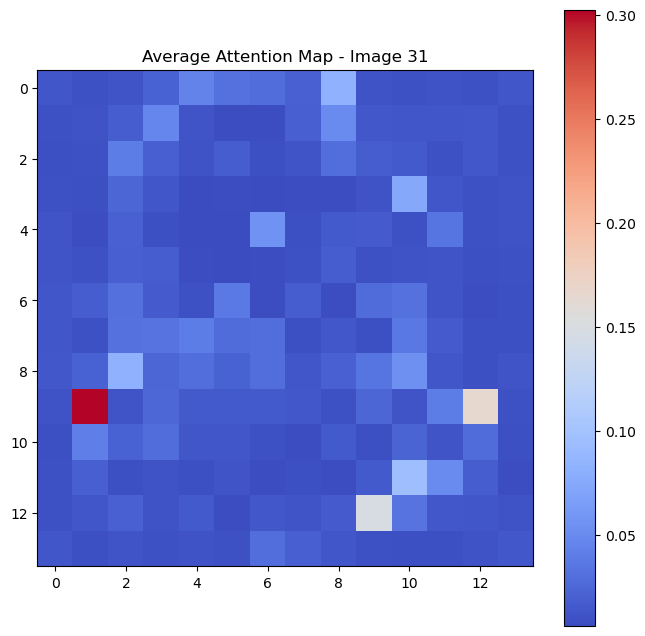

Testing DataLoader 0:  10%|▉         | 2/21 [00:18<02:53,  0.11it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [106]:
# Test the model
trainer.test(model, dataloaders=test_loader)